<a href="https://colab.research.google.com/github/neuralnetworksrs/Tarea-2/blob/master/Parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Aplicaciones Recientes de Redes Neuronales </H3>
<hr style="height:2px;border:none"/>

**Temas**  

* Diseño e implementación detallado de Redes Recurrentes (RNN) y sus derivados.
* Compuertas LSTM y GRU. 
* Arquitectura Encoder-Decoder para problemas de *traducción*.
* Arquitectura de Autoencoder para reducción de dimensionalidad.
* Modelos generativos profundos: VAEs (*Variational Autoencoder*)

** Formalidades **  
* Equipos de trabajo de: 2-3 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: por definir.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF395-I-2019]

<hr style="height:2px;border:none"/>
La tarea se divide en secciones:

[0+.](#bonus) Bonus  
[1.](#primero) RNN sobre texto  
[2.](#segundo) *Encoder-Decoder* sobre imágenes    
[3.](#tercero) *Encoder-Decoder* sobre Texto    
[4.](#cuarto) Distintos tipos de autoencoders (AEs) en MNIST    

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a id="primero"></a>
## 1. RNN sobre texto
---

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y *tagger*. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas de redes recurrentes.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />


Descargue los datos de la página de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__ y cárguelos mediante *pandas*.

In [0]:
import numpy as np
import pandas as pd
df_ner = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


a) En esta primera instancia trabajaremos con la tarea de realizar un NER tag (Named Entity Recognition) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo many to many, es decir, la entrada es una secuencia y la salida es una secuencia, sin shift, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset ¿Por qué es conveniente utilizar lemma en vez de la misma palabra?

In [0]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]
dataset.head()

,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O


Es conveniente usar lemma en vez de la misma palabra porque así nos ahorramos aumentar las dimensiones por cada palabra diferente en el dataset. Le da valor según el contexto, además de categorizar las palabras desde su raíz (Stemming)

Luego de esto cree una estructura que contendrá todas las sentencias u oraciones (lista de *lemmas*) y otra estructura que contendrá las etiquetas (lista de *tags*). **¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?**

In [0]:
n_used = 500000 #data to use-- your choice
dataX_raw,dataY_raw = [],[]
lemmas,labels = set(), set()  #uniques
sentence= []
labels_sentence = []
for fila in dataset.values[:n_used]:
    if fila[-1]=="__START1__": 
        dataX_raw.append(sentence)
        dataY_raw.append(labels_sentence)
        sentence= []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0]) #add lemma
    labels_sentence.append(fila[3]) #TAG
dataX_raw = dataX_raw[1:]
dataY_raw = dataY_raw[1:]


In [0]:
print("Total de sentencias:",len(dataX_raw))
print("Total de etiquetas:",len(labels))
print("Total de palabras:",len(lemmas))

Total de sentencias: 22901
Total de etiquetas: 17
Total de palabras: 12450


In [0]:
equal_dimension = True
for i in range(0,len(dataX_raw)):
  for j in range(0,len(dataX_raw)):
    if len(dataX_raw[i]) != len(dataY_raw[j]):
      equal_dimension = False
      break
if equal_dimension:
  print('Tienen la misma dimensión todos los datos')
else:
  print('No tienen la misma dimensión todos los datos')

No tienen la misma dimensión todos los datos


> b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?**[[1]](#refs) Realice un gráfico de la cantidad de datos por clase. Comente. 1/n

In [0]:
sentence_frequency = {}
word_frequency = {}

for sentence in dataX_raw:
  if len(sentence) in sentence_frequency.keys():
      sentence_frequency[len(sentence)] += 1 
  else:
      sentence_frequency[len(sentence)] = 0
  for word in sentence:
    if word in word_frequency:
      word_frequency[word] += 1 
    else:
      word_frequency[word] = 0
      
tag_frequency = {}

for sentence in dataY_raw:
    for tag in sentence:
        if tag != 'O':
          if tag not in tag_frequency.keys():
            tag_frequency[tag] = 1
          else:
            tag_frequency[tag] += 1

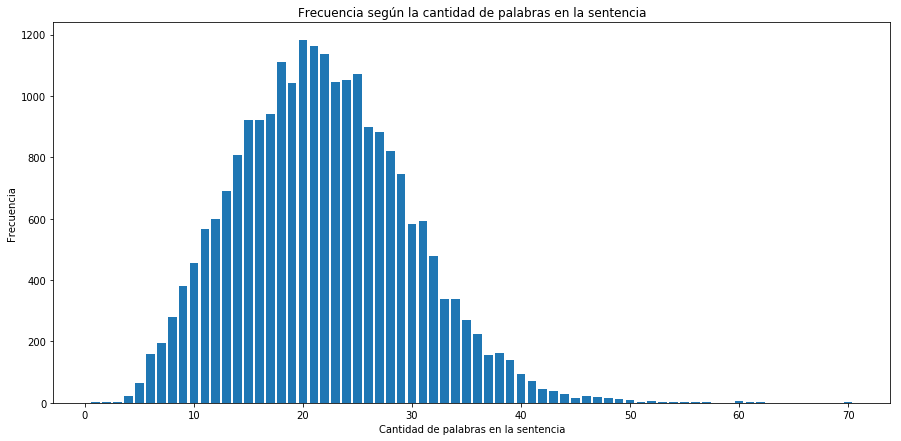

In [0]:
plt.figure(figsize=(15,7))

plt.bar(sentence_frequency.keys(), sentence_frequency.values())
plt.xlabel('Cantidad de palabras en la sentencia')
plt.ylabel('Frecuencia')
plt.title('Frecuencia según la cantidad de palabras en la sentencia')

plt.show()

Se puede ver en la distribución de los datos, que el número de palabras en la sentencia más repetidos están entre 15 y 25. La distribución se asemeja a una distribución normal.

In [0]:
tags_tuples = [(tag_frequency[key], key) for key in tag_frequency.keys()]
tags_tuples.sort(reverse=True)

x_ticks = []
y_ticks = []

for i in range(len(tags_tuples)):
    y_ticks.append(tags_tuples[i][0])
    x_ticks.append(tags_tuples[i][1])

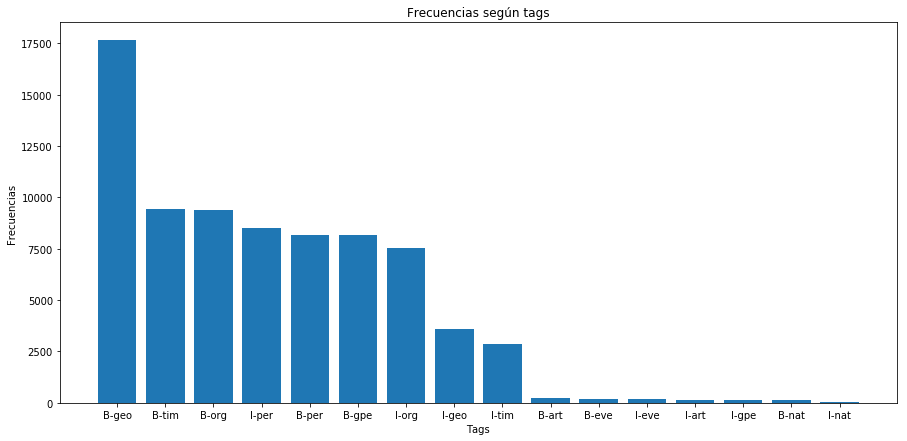

In [0]:
plt.figure(figsize=(15,7))

plt.bar(x_ticks, y_ticks)
plt.xlabel('Tags')
plt.ylabel('Frecuencias')
plt.title('Frecuencias según tags')

plt.show()

In [0]:
B_geo = 100*y_ticks[0]/sum(y_ticks)
B_tim = 100*y_ticks[1]/sum(y_ticks)
B_org = 100*y_ticks[2]/sum(y_ticks)
print("Porcentaje de ocupado de los primeros 3 Tags con mayor frecuencia B-geo %d, B-tim %d, B-org %d"%(B_geo,B_tim,B_org))

Porcentaje de ocupado de los primeros 3 Tags con mayor frecuencia B-geo 23, B-tim 12, B-org 12


Los primeros 3 tags con mayor frecuencia, abarcan aproximadamente el 46% del dataset, por lo cual hay un claro sesgamiento el cual se tiene que evitar para que la red no clasfique los textos basandose exclusivamente en la frecuencia.



In [0]:
keys_first_50 = sorted(word_frequency, key=word_frequency.get, reverse=True)[:50]

keys_first_50_hash = {}
  
for key in keys_first_50:
  keys_first_50_hash[key] = word_frequency[key]

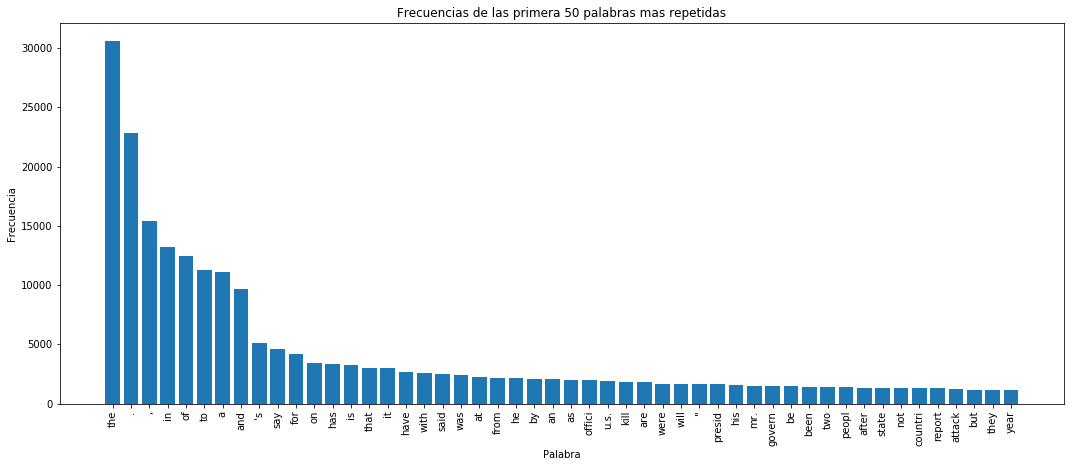

In [0]:
plt.figure(figsize=(18,7))

plt.bar(keys_first_50_hash.keys(), keys_first_50_hash.values())
plt.xticks(rotation='vertical')
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")
plt.title("Frecuencias de las primera 50 palabras mas repetidas")
plt.show()

Se puede ver que dentro de las palabras más repetidas, se encuentran caracteres que no corresponden a palabras, por lo cual se procede a sacarlos del vocabulario.

In [0]:
vocab = {}

for word in dataset.values[:]:
    if word[0].isalpha() and  word[0] in vocab .keys():
      vocab [word[0]] += 1
    elif word[0].isalpha() and  word[0] not in vocab .keys():
      vocab [word[0]] = 1
            
            
vocab_list = [(vocab [key], key) for key in vocab .keys()]
vocab_list.sort(reverse=True)

x_ticks = []
y_ticks = []

for i in range(len(vocab_list)):
    x_ticks.append(np.log(i + 1))
    y_ticks.append(np.log(vocab_list[i][0]))

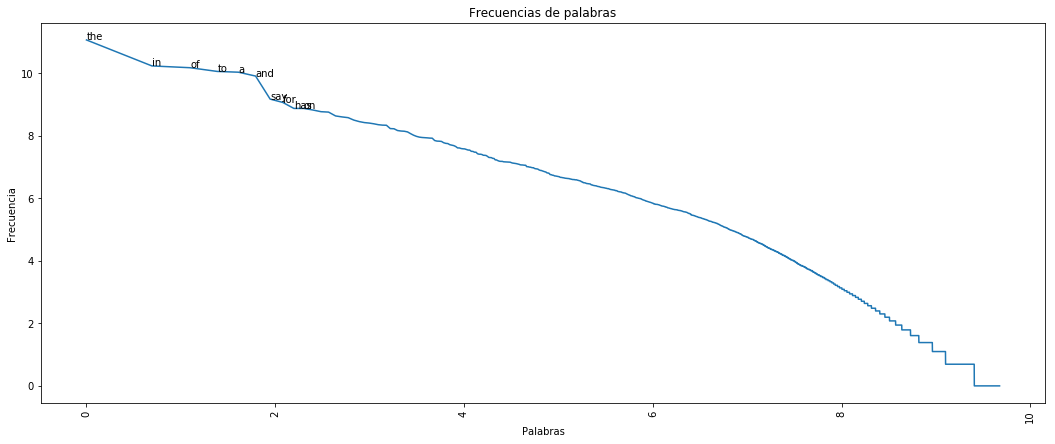

In [0]:
plt.figure(figsize=(18, 7))

plt.plot(x_ticks, y_ticks)
for i, txt in enumerate(vocab_list):
  if i < 10:
    plt.annotate(txt[1], (x_ticks[i], y_ticks[i]))
plt.xticks(rotation='vertical')
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.title("Frecuencias de palabras")

plt.show()

La ley ZIpfs es una ley empírica según la cual en una determinada lengua la frecuencia de aparición de distintas palabras sigue una distribución que puede aproximarse por :
$$P_{n} \sim \frac{1}{n^{a}}$$

donde $P_{n} $ representa la frecuencia de la n-ésima palabra más frecuente y el exponente $a$ es un número real positivo, en general ligeramente superior a 1. Esto significa que el segundo elemento se repetirá aproximadamente con una frecuencia de 1/2 de la del primero, el tercer elemento con una frecuencia de 1/3 y así sucesivamente

Se puede ver que apartir aproximadamente de la palabra $and$, se empieza a cumplir la ley de Zipfs, dejanso los primeros 5 términos fuera de la ley por la cantidad de repeticiones que tuvieron dentro del conjunto.


> c) Para representar cada posible *tag* y *lemma* de modo que la red pueda manejarlo, será necesario codificarlos a un número único (*indice*) ¿Cuántos *tags* y *lemmas* distintos existen?  Comente sobre el significado del *tag* para cada *lemma*. **Finalmente mida el largo máximo de entre todas las sentencias**.

In [0]:
n_labels = len(labels)
lab2idx = {t: i for i, t in enumerate(labels)}
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY_raw] #Converting tags to indexs
n_lemmas = len(lemmas)
lemma2idx = {w: i for i, w in enumerate(lemmas)} 
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX_raw] #Converting text to indexs

In [0]:
def total_indexes(data):
  indexes = [set(ids) for ids in data]
  total_index = indexes[0]
  for index in indexes:
    total_index = index.union(total_index)
   
  return total_index, len(total_index)

tags_index, tags_index_quantity = total_indexes(dataY)
text_index, text_index_quantity = total_indexes(dataX)

In [0]:
print("Existen %d tags distintos" % tags_index_quantity)
print("Existen %d lemmas distintos" % text_index_quantity)
dataset.tag.unique()

Existen 17 tags distintos
Existen 12450 lemmas distintos


array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

Existen diferentes tipos de etiques para clasificar las palabras:

* geo = entidad geográfica
* org = Organización
* por = persona
* gpe = entidad geopolítica
* tim = indicador de tiempo
* arte = artefacto
* eve = Evento
* nat = Fenómeno natural


Una etiqueta O indica que un token no pertenece a ningún fragmento

El prefijo I antes de una etiqueta indica que la etiqueta está dentro de un fragmento.

El prefijo B antes de una etiqueta indica que la etiqueta es el comienzo de un fragmento.



In [0]:
max_input_lenght = 0
for group in dataX_raw:
  for sentence in group:
    if max_input_lenght < len(sentence):
      max_input_lenght = len(sentence)
      
print("El largo máximo entre todas las sentencias es %d" % max_input_lenght)

El largo máximo entre todas las sentencias es 64


> d) Debido a la distinta extensión de textos se deberá **realizar *padding* para estandarizar el largo**,
considere algun carácter especial **no presente en el vocabulario** para codificar el espacio en blanco en ambos (entrada y salida), por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*N, N*]. Decida, respecto al cómo funciona una red recurrente y su *memoria*, sobre qué le parece más conveniente al momento de rellenar con un valor especial ¿Al principio o al final de la sentencia? Comente

In [0]:
lemma2idx["-|-"] = n_lemmas
lab2idx["-|-"] = n_labels
n_labels +=1
n_lemmas +=1
from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX, maxlen=max_input_lenght,padding='pre',value=lemma2idx["-|-"])
y = sequence.pad_sequences(dataY, maxlen=max_input_lenght,padding='pre',value=lab2idx["-|-"])
del dataY[:],dataX[:]

Using TensorFlow backend.


La red recurrente ocupa ciclos de realimentación para mantener información durante algunos epochs a través de los datos de la salida que inscrustan(embedding) sus resultados
en la capa de entrada, por lo que es más conveniente tener el valor especial al principo de la sentencia.

> e) Para poder generar una representación adecuada sobre los datos de entrada que permita realizar operaciones lineales, deberá generar una representación a un vector denso. Para ésto se utilizará la arquitectura de autoencoder **Word2Vec** [[2]](#refs) sobre textos *raws* de largo variable, en donde el *encoder* codifica una palabra categórica (*target*) a un vector denso de dimensionalidad $d$ mientras que el *decoder* genera palabras en el contexto (*context*) de la palabra *target* (en una vecindad alrededor). La idea detrás es que palabras similares sean proyectadas a una región cercana en el espacio de *embedding* ¿Cuál es la importancia del parámetro min_count? ¿Cuántos *lemmas* ve Word2Vec?

In [0]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 32
window_size = 5
nb_epoch = 5
batch_size = 6000
min_count = 3
model = Word2Vec(dataX_raw,size=EMBEDDING_DIM,window=window_size,batch_words=batch_size,iter=nb_epoch,
                 min_count=min_count, negative=5,sg=1) #sg=1 mean skip-gram
embeddings_index = {vocab_word: model.wv[vocab_word] for vocab_word in model.wv.vocab}
print('Cantidad de lemmas ', len(embeddings_index.keys()))

Cantidad de lemmas  6957


El parámetro de min_count sirve para ignorar todas las palabras con frecuencia absoluta menor que el valor del parámetro

Genere una matriz de *embeddings* que se utilizarán como capa neuronal.


In [0]:
embedding_matrix = np.zeros((n_lemmas, EMBEDDING_DIM))
for word, i in lemma2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: #if word does not has embedding
        embedding_matrix[i] = embedding_vector

Luego, para poder realizar una clasificación sobre los datos en la salida será necesario representarlos *one hot vectors*, esto resultará en un arreglo tridimensional.

In [0]:
from keras.utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])

> f) Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

In [0]:
print('Dimensiones conjunto de entrada entranamiento ', X_train.shape)
print('Dimensiones conjunto de entrada prueba ', X_test.shape)
print('Dimensiones conjunto de salida entranamiento ', y_train.shape)
print('Dimensiones conjunto de salida prueba ', y_test.shape)

Dimensiones conjunto de entrada entranamiento  (16030, 64)
Dimensiones conjunto de entrada prueba  (6871, 64)
Dimensiones conjunto de salida entranamiento  (16030, 64, 18)
Dimensiones conjunto de salida prueba  (6871, 64, 18)


> g) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red es una por cada instante de tiempo que se necesita entregar un *output*. La primera capa de la red a construir debe tener los vectores de *embedding* encontrados por **Word2Vec**. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**. Entrene y luego evalúe su desempeño sobre ambos conjuntos. 

In [0]:
import matplotlib.pyplot as plt
def plot_model_losses(resume): 
  plt.figure(figsize=(15, 7))
  plt.plot(resume.history['loss'])
  plt.plot(resume.history['val_loss'])
  plt.xlabel("Epoch")
  plt.ylabel("Loss") 
  plt.legend(["Train Loss", "Val Loss"], loc="upper right")
  plt.title("Sets Losses")
  plt.show()
  
  print("Final Train Loss:",resume.history['loss'][-1])
  print("Val loss:",min(resume.history['val_loss']))

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
model_LSTM.add(LSTM(units=100,return_sequences=True))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model_LSTM.summary()
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam')
resume = model_LSTM.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 64, 32)            398432    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64, 100)           53200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 100)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 64, 18)            1818      
Total params: 453,450
Trainable params: 55,018
Non-trainable params: 398,432
_________________________________________________________________
Train on 16030 samples, validate on 6871 samples
Epoch 1/15
16030/16030 [==============================] - 14s 879us/step - loss: 0.8942 - val_loss: 0.3813
Epoch 2/15
16030/16030 [==============================] - 13s 824us/step - loss: 0.3372 - val_loss: 0.2933


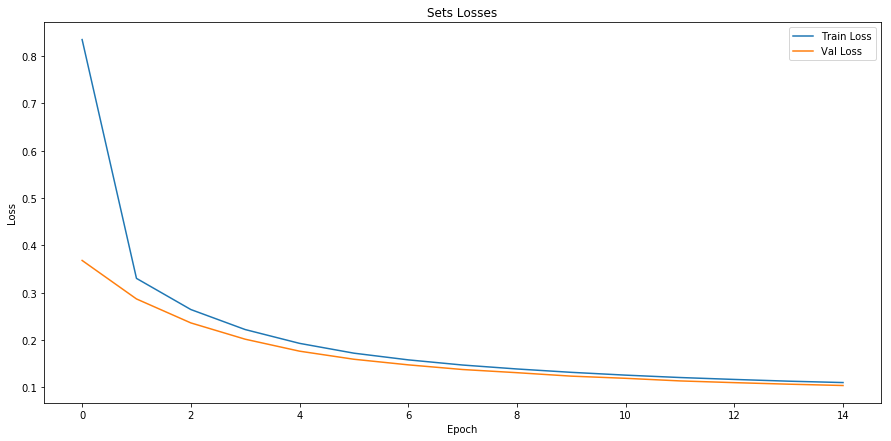

Final Train Loss: 0.10997347007188958
Val loss: 0.1037519976492359


In [0]:
plot_model_losses(resume)

Para evaluar su modelo utilice una métrica adecuada para el desbalance presente entre las clases como identificó en el punto b). Tenga presente en este punto el **no evaluar** la clase/símbolo que añadió para realizar *padding* a los *tag*.  
*Hint: podría "truncar" la salida predicha hasta el largo real de esa sentencia*

In [0]:
def truncate_predicted_output(model, X_test, y_test):
  dataY_pred = model.predict_classes(X_test,verbose=0)
  dataY_pred_truncated = []
  y_test_transformed = []
  y_test_two = []
  
  for example in y_test:
      y_test_transformed.append([np.argmax(y, axis=None, out=None) for y in example])

  sentence_index = 0
  for sentence in X_test:
    word_index = 0
    for word in sentence:
      if word+1 == lemma2idx["-|-"]:
        y_test_two.append(y_test_transformed[sentence_index][:word_index])
        dataY_pred_truncated.append(dataY_pred[sentence_index][:word_index])
        break
      word_index += 1
    sentence_index += 1
    
  return dataY_pred_truncated, y_test_two

In [0]:
y_pred, y_test_two = truncate_predicted_output(model_LSTM, X_test, y_test)
dataY_pred = model_LSTM.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
dataY = y_test.argmax(axis = 2)

In [0]:
from sklearn.metrics import f1_score
f1_score_bydata_normal = [f1_score(true, pred ,average='weighted') for true,pred in zip(dataY,dataY_pred) ]
f1_score_bydata_lstm = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_two,y_pred) ]
print("F1 score on test: ", np.mean(f1_score_bydata_normal) )
print("\nF1 score on test truncated pred LSTM: ", np.mean(f1_score_bydata_lstm) )


F1 score on test:  0.9646954482497682

F1 score on test truncated pred LSTM:  0.977504508983949


> h) Varíe con seguir entrenando la capa de embedding seteada al definir la arquitectura, ésto es cambiar a *trainable=True*, compare el desempeño y el número de parámetros (entrenables) con lo anterior. Comente

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed
model_LSTM_T = Sequential()
model_LSTM_T.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
model_LSTM_T.add(LSTM(units=100,return_sequences=True))
model_LSTM_T.add(Dropout(0.2))
model_LSTM_T.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model_LSTM_T.summary()
model_LSTM_T.compile(loss='categorical_crossentropy', optimizer='adam')
resume = model_LSTM_T.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 64, 32)            398432    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64, 100)           53200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 100)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 64, 18)            1818      
Total params: 453,450
Trainable params: 453,450
Non-trainable params: 0
_________________________________________________________________
Train on 16030 samples, validate on 6871 samples
Epoch 1/15
16030/16030 [==============================] - 15s 920us/step - loss: 0.8173 - val_loss: 0.3251
Epoch 2/15
16030/16030 [==============================] - 14s 844us/step - loss: 0.2733 - val_loss: 0.2127
Epoch

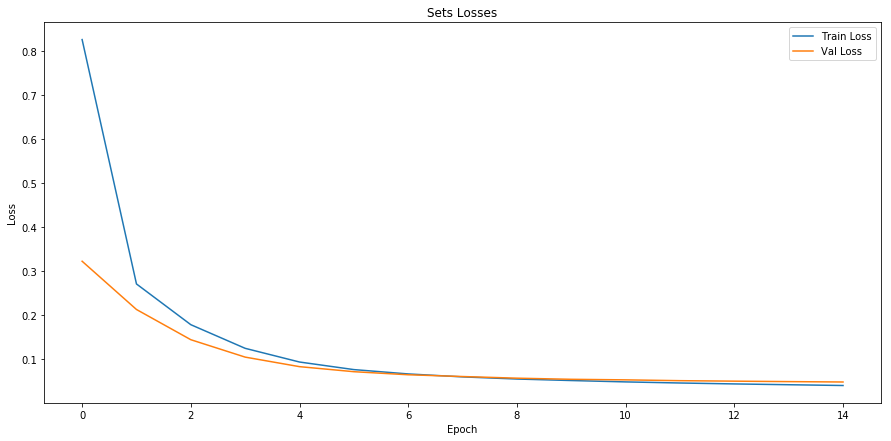

Final Train Loss: 0.04082421561701924
Val loss: 0.04876881462713375


In [0]:
plot_model_losses(resume)

> i) Experimente con cambiar la *gate* de recurrencia a una con menos parámetros pero que mantiene la capacidad de memoria de la LSTM, ésta es la compuerta GRU. Comente sobre los resultados esperados y observados.

In [0]:
from keras.layers import GRU
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
model.add(GRU(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
resume = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)                                                    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 64, 32)            398432    
_________________________________________________________________
gru_1 (GRU)                  (None, 64, 100)           39900     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 100)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 64, 18)            1818      
Total params: 440,150
Trainable params: 440,150
Non-trainable params: 0
_________________________________________________________________
Train on 16030 samples, validate on 6871 samples
Epoch 1/15
16030/16030 [==============================] - 12s 761us/step - loss: 0.8226 - val_loss: 0.2608
Epoch 2/15
16030/16030 [==============================] - 11s 704us/step - loss: 0.2058 - val_loss: 0.1520
Epoch

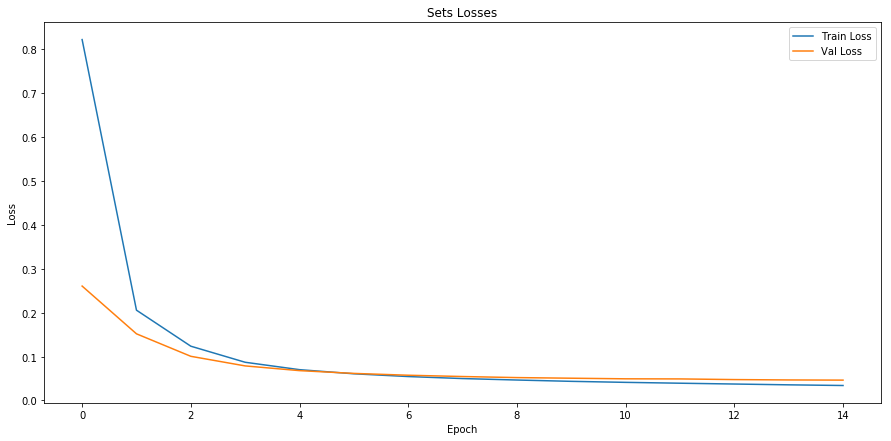

Final Train Loss: 0.03416724751842297
Val loss: 0.046432609252253225


In [0]:
plot_model_losses(resume)

In [0]:
y_pred, y_test_two = truncate_predicted_output(model_LSTM_T, X_test, y_test)

f1_score_bydata_lstm_t = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_two,y_pred) ]
print("F1 score on test: ", np.mean(f1_score_bydata_normal) )
print("\nF1 score on test truncated pred LSTM: ", np.mean(f1_score_bydata_lstm) )
print("\nF1 score on test truncated pred LSTM Trained: ", np.mean(f1_score_bydata_lstm_t) )


F1 score on test:  0.9646954482497682

F1 score on test truncated pred LSTM:  0.977504508983949

F1 score on test truncated pred LSTM Trained:  0.9900195369786975



> j) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen. Mejore la red utilizando una red neuronal recurrente Bidireccional, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas*. Comente cuál debiera ser la forma correcta de usar el parámetro merge_mode (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. ¿Mejora o empeora el desempeño? Analice.

In [0]:
from keras.layers import Bidirectional
model_BI = Sequential()
model_BI.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
gate_layer = LSTM(units=100,return_sequences=True)
model_BI.add(Bidirectional(gate_layer, merge_mode='concat'))
model_BI.add(Dropout(0.2))
model_BI.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model_BI.compile(loss='categorical_crossentropy', optimizer='adam')
model_BI.summary()
resume = model_BI.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 64, 32)            398432    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64, 200)           106400    
_________________________________________________________________
dropout_9 (Dropout)          (None, 64, 200)           0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 64, 18)            3618      
Total params: 508,450
Trainable params: 110,018
Non-trainable params: 398,432
_________________________________________________________________
Train on 16030 samples, validate on 6871 samples
Epoch 1/15
16030/16030 [==============================] - 30s 2ms/step - loss: 0.5412 - val_loss: 0.2348
Epoch 2/15
16030/16030 [==============================] - 28s 2ms/step - loss: 0.2120 - val_loss: 0.1842
Epo

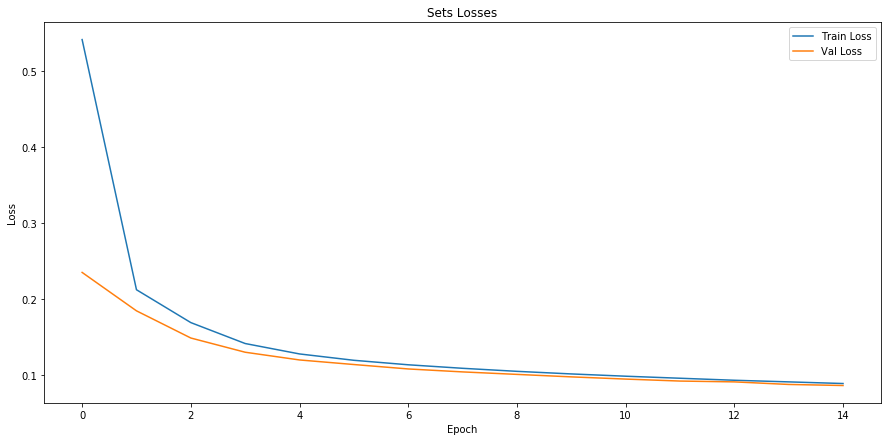

Final Train Loss: 0.08854416119572675
Val loss: 0.0859419239847321


In [0]:
plot_model_losses(resume)

In [0]:
y_pred, y_test_two = truncate_predicted_output(model_BI, X_test, y_test)

f1_score_bydata_bi = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_two,y_pred) ]
print("F1 score on test: ", np.mean(f1_score_bydata_normal) )
print("\nF1 score on test truncated pred LSTM: ", np.mean(f1_score_bydata_lstm) )
print("\nF1 score on test truncated pred LSTM Trained: ", np.mean(f1_score_bydata_lstm_t) )
print("\nF1 score on test truncated pred BI: ", np.mean(f1_score_bydata_bi) )


F1 score on test:  0.9646954482497682

F1 score on test truncated pred LSTM:  0.977504508983949

F1 score on test truncated pred LSTM Trained:  0.9900195369786975

F1 score on test truncated pred BI:  0.9820812893300784


> k) En base a lo experimentado, **mejore el desempeño de las redes encontradas**, ya sea utilizando y/o combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (en https://keras.io/layers/recurrent/), cambiar los vectores de *embedding* por unos entrenados en otros dataset más grandes (https://nlp.stanford.edu/projects/glove/), entre otros.

In [0]:
from keras.layers import Bidirectional, SimpleRNN
model_BI_2 = Sequential()
model_BI_2.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
gate_layer = SimpleRNN(units=100,return_sequences=True)
model_BI_2.add(Bidirectional(gate_layer, merge_mode='concat'))
model_BI_2.add(Dropout(0.2))
model_BI_2.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model_BI_2.compile(loss='categorical_crossentropy', optimizer='adam')
model_BI_2.summary()
resume = model_BI_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 64, 32)            398432    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64, 200)           26600     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 200)           0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 64, 18)            3618      
Total params: 428,650
Trainable params: 30,218
Non-trainable params: 398,432
_________________________________________________________________
Train on 16030 samples, validate on 6871 samples
Epoch 1/15
16030/16030 [==============================] - 10s 641us/step - loss: 0.3969 - val_loss: 0.2053
Epoch 2/15
16030/16030 [==============================] - 9s 539us/step - loss: 0.1836 - val_loss: 0.1563
E

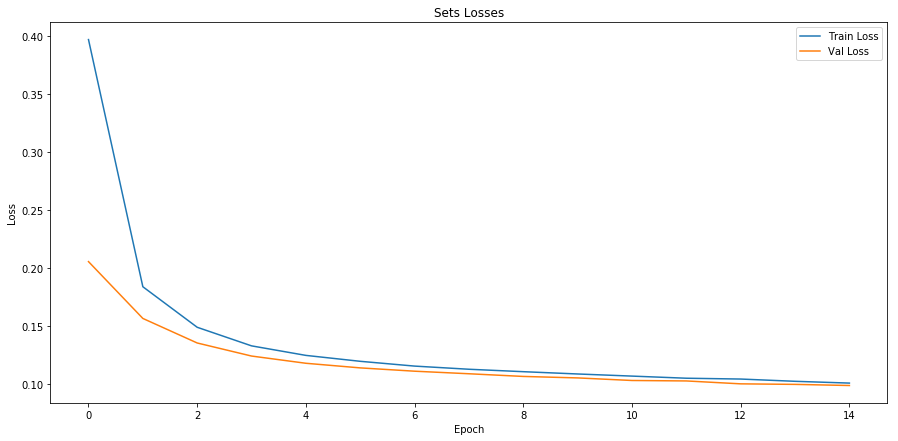

Final Train Loss: 0.10049398699757908
Val loss: 0.09841390859849102


In [0]:
plot_model_losses(resume)

In [0]:
y_pred, y_test_two = truncate_predicted_output(model_BI_2, X_test, y_test)

f1_score_bydata_bi_two = [f1_score(true, pred ,average='weighted') for true,pred in zip(y_test_two,y_pred) ]
print("F1 score on test: ", np.mean(f1_score_bydata_normal) )
print("\nF1 score on test truncated pred LSTM: ", np.mean(f1_score_bydata_lstm) )
print("\nF1 score on test truncated pred LSTM Trained: ", np.mean(f1_score_bydata_lstm_t) )
print("\nF1 score on test truncated pred BI LSTM: ", np.mean(f1_score_bydata_bi) )
print("\nF1 score on test truncated pred BI RNN: ", np.mean(f1_score_bydata_bi_two) )

F1 score on test:  0.9646954482497682

F1 score on test truncated pred LSTM:  0.977504508983949

F1 score on test truncated pred LSTM Trained:  0.9900195369786975

F1 score on test truncated pred BI LSTM:  0.9820812893300784

F1 score on test truncated pred BI RNN:  0.9775779119265926


> l) Utilice la red con mejor desempeño encontrada, idealmente la encontrada en (j), y **muestre las predicciones** del *NER tager*, sobre algún ejemplo de pruebas, comente.  

In [0]:
inv_lemma = {v: k for k, v in lemma2idx.items()}
inv_labels = {v: k for k, v in lab2idx.items()}
idx = np.random.choice(np.arange(y_test.shape[0]), size=7, replace=False)

In [0]:
for i in idx:
  p = model_LSTM.predict([[X_test[i]]])  #(np.array([X_test[0]]))
  p = np.argmax(p, axis=-1)
  labels_list = list(labels)
  lemmas_list = list(lemmas)
  print("\n{:15}: {:7} , {}".format("Lemma", "Pred", "True"))
  for word,pred,true in zip(X_test[i],p[0],y_test[i]):
      if word+1 != n_lemmas:
          print("{:15}: {:7} , {}".format(inv_lemma[word],inv_labels[pred],inv_labels[np.argmax(true, axis=None, out=None)]))


Lemma          : Pred    , True
in             : O       , O
an             : O       , O
attempt        : O       , O
to             : O       , O
control        : O       , O
the            : O       , O
outbreak       : O       , O
,              : O       , O
the            : O       , O
govern         : O       , O
has            : O       , O
ban            : O       , O
the            : O       , O
sale           : O       , O
of             : O       , O
water          : O       , O
at             : O       , O
market         : O       , O
.              : O       , O

Lemma          : Pred    , True
disput         : O       , O
between        : O       , O
franc          : B-geo   , B-geo
and            : O       , O
the            : O       , O
unit           : B-geo   , B-org
kingdom        : I-geo   , I-org
for            : O       , O
most           : O       , O
of             : O       , O
the            : O       , O
18th           : O       , B-tim
centuri        : O 

<a id="refs"></a>
## Referencias
[1] https://es.wikipedia.org/wiki/Ley_de_Zipf    
[2] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). *Efficient estimation of word representations in vector space*. arXiv preprint arXiv:1301.3781.    
[3] Cho, K., Van Merriënboer, B., Bahdanau, D., & Bengio, Y. (2014). *On the properties of neural machine translation: Encoder-decoder approaches*. arXiv preprint arXiv:1409.1259.  
[4] Pal, N. R., & Pal, S. K. (1993). *A review on image segmentation techniques*. Pattern recognition, 26(9), 1277-1294.  
[5] Badrinarayanan, V., Kendall, A., & Cipolla, R. (2017). *Segnet: A deep convolutional encoder-decoder architecture for image segmentation*. IEEE transactions on pattern analysis and machine intelligence, 39(12), 2481-2495.  
[6] Papineni, K., Roukos, S., Ward, T., & Zhu, W. J. (2002, July). *BLEU: a method for automatic evaluation of machine translation*. In Proceedings of the 40th annual meeting on association for computational linguistics (pp. 311-318). Association for Computational Linguistics.  
[7] Kingma, D. P., & Welling, M. (2013). *Auto-encoding variational bayes*. arXiv preprint arXiv:1312.6114.  
[8] https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence     
[9] Dumoulin, V., & Visin, F. (2016). *A guide to convolution arithmetic for deep learning*. arXiv preprint arXiv:1603.07285.  also: https://github.com/vdumoulin/conv_arithmetic  
[10] Jang, E., Gu, S., & Poole, B. (2016). *Categorical reparameterization with gumbel-softmax*. arXiv preprint arXiv:1611.01144.  
[11] https://en.wikipedia.org/wiki/Cluster_analysis  